In [ ]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
from utils import smart_inverse
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)

In [ ]:
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)


energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [ ]:
ham.potential = None
ham.mu1=0.1
ham.mu2=0.1

In [ ]:
X = ham.create_hamiltonian(False)

In [ ]:
energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [ ]:
energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:
# Sweep Fermi energy and plot transmission for QPC
ham = Hamiltonian("qpc")

ham.W = 10
ham.L = 30
ham.t = 1.0
ham.o = 0.0
ham.Vg = .1  # Moderate barrier

gf = GreensFunction(ham)

energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:


# # --- Plotting Code ---

# # Extract x and y coordinates from the list of Atom objects
# x_coords = [atom.x for atom in structure]
# y_coords = [atom.y for atom in structure]

# # Create the plot
# plt.figure(figsize=(8, 12))
# plt.scatter(x_coords, y_coords, s=150, edgecolors='black', facecolors='skyblue', zorder=5)

# # Add text labels to identify each atom's index in the list
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.text(x + 0.05, y + 0.05, str(i), fontsize=9, ha='left', va='bottom', zorder=10)

# # Formatting the plot for clarity
# plt.title("Plot of Generated Atom Coordinates", fontsize=16)
# plt.xlabel("X coordinate", fontsize=12)
# plt.ylabel("Y coordinate", fontsize=12)
# plt.axis('equal')  # This is CRUCIAL for correctly visualizing geometric structures
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [ ]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag")
ham.Nx=20
ham.Ny=20

gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = [None] * 300

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()





In [ ]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag", periodic=True)
ham.Nx=20


gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()





In [2]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag", False)
ham.Nx=5
ham.Ny = 5

gf = GreensFunction(ham)


H00, H01, H10 = ham.get_H00_H01_H10()
X = gf.lead_self_energy.self_energy("left", -2.45819398)
# energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()

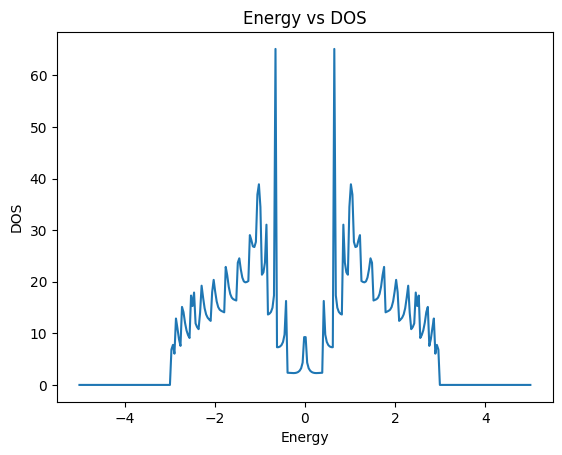

In [3]:

plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

[[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
Starting NEGF calculation...
0.49996747418712684
(0.9-5e-13j)
(0.9-5e-13j)
(-0.8999999999989676-0.4358898943535673j)
Calculation finished.
Total Current I = 0.0000 uA


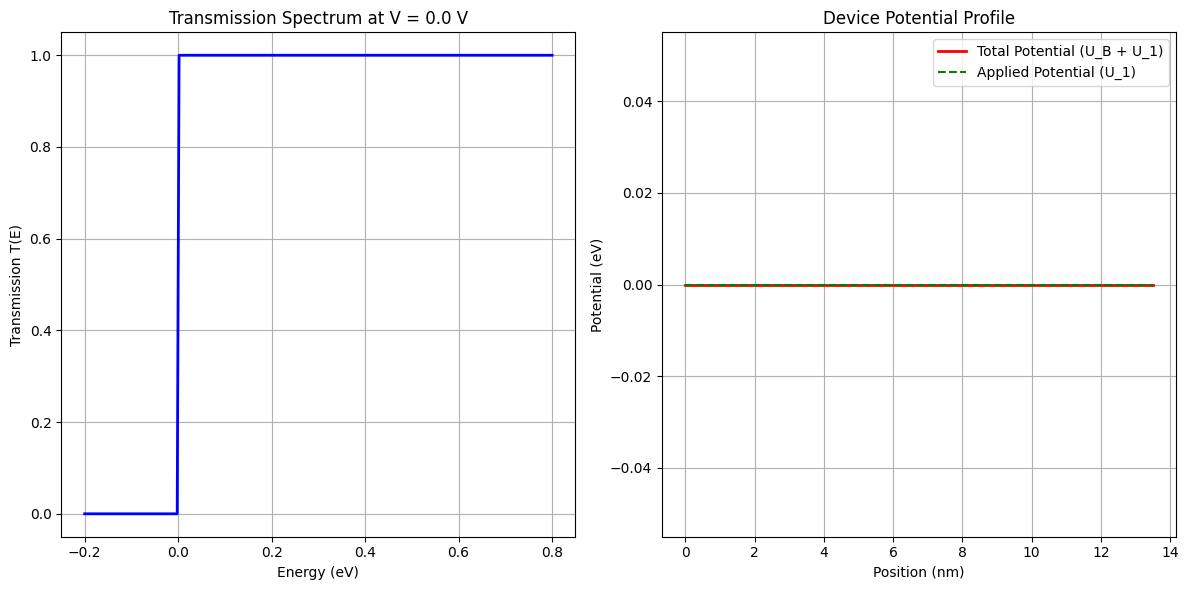

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def run_transport_simulation():
    """
    Translates and runs a MATLAB script for calculating quantum transport
    properties using the Non-Equilibrium Green's Function (NEGF) method.
    """
    # --- Constants (all MKS, except energy which is in eV) ---
    hbar = 1.0545718e-34  # Corrected hbar value
    q = 1.60217662e-19
    m0 = 9.10938356e-31
    m_eff = 0.25 * m0  # Effective mass
    
    # This constant combines q^2 / (2*pi*hbar)
    # The original MATLAB code had a typo IE=(q*q)/(2*pi*hbar) which is G0/pi
    # The quantum of conductance is G0 = 2*q^2/h = q^2/(pi*hbar)
    IE = q**2 / (np.pi * hbar) 

    Ef = 0.1  # Fermi energy in eV
    kT = 0.025 # Thermal energy in eV

    # --- Inputs ---
    a = 3e-10  # Lattice spacing in meters
    # Hopping parameter in eV
    t0 = 1#hbar**2 / (2 * m_eff * a**2 * q) 

    # Device structure: Number of sites in Source, Channel, Drain
    # This corresponds to the Resonant Tunneling (RT) barrier case in the MATLAB script
    NS = 15
    NC = 16
    ND = 15
    Np = NS + NC + ND # Total number of points

    # --- Hamiltonian Matrix ---
    # Define the potential barrier UB
    # This setup creates two small barriers, simulating a resonant tunneling diode
    UB = np.zeros(Np)
    UB[NS : NS+4] = 0.4 * 0  # First barrier
    # The middle part from NS+4 to NS+NC-4 is zero
    UB[NS+NC-4 : NS+NC] = 0.4 * 0# Second barrier
    
    # Create the tight-binding Hamiltonian matrix T
    # Main diagonal
    main_diag = 2 * t0 * np.ones(Np)
    # Off-diagonals for nearest-neighbor hopping
    off_diag = -t0 * np.ones(Np - 1)
    
    T = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    print(T)
    # Add the potential barrier to the Hamiltonian
    T = T + np.diag(UB)

    # --- Bias ---
    V = 0.0  # Applied bias in Volts
    mu1 = Ef + (V / 2)  # Chemical potential of the source
    mu2 = Ef - (V / 2)  # Chemical potential of the drain

    # Applied potential profile U1 due to bias
    # It drops linearly across the channel region
    U1 = np.concatenate([
        (V / 2) * np.ones(NS),
        np.linspace(V / 2, -V / 2, NC),
        (-V / 2) * np.ones(ND)
    ])

    # --- Energy Grid for Green’s function method ---
    NE = 501  # Number of energy points
    E = np.linspace(-0.2, 0.8, NE)
    dE = E[1] - E[0]
    zplus = 1j * 1e-12  # Small imaginary part for Green's functions

    # Fermi-Dirac distribution functions for source and drain
    f1 = 1 / (1 + np.exp((E - mu1) / kT))
    f2 = 1 / (1 + np.exp((E - mu2) / kT))

    # --- Main Loop for Transmission and Current Calculation ---
    I = 0.0  # Initialize current
    TM = np.zeros(NE) # Array to store transmission values

    print("Starting NEGF calculation...")
    for k in range(NE):
        Ek = E[k]
        
        # --- Self-Energies (sig1, sig2) ---
        # Self-energy for the source contact (left lead)
        # It's a non-zero matrix element only at the (0,0) position
        ck1 = 1 - (Ek + zplus - U1[0] - UB[0]) / (2 * t0)
        # Ensure the argument for arccos is within the valid range [-1, 1]
        # to avoid NaN results from small numerical errors
        if (Ek==.2):
            print(ck1)
        ck1 = np.clip(ck1, -1, 1) 
        ka1 = np.arccos(ck1)
        
        sig1 = np.zeros((Np, Np), dtype=complex)
        sig1[0, 0] = -t0 * np.exp(1j * ka1)
        if (Ek==.2):
            print(ck1)
            print(sig1[0,0])

        # Self-energy for the drain contact (right lead)
        # It's a non-zero matrix element only at the (Np-1, Np-1) position
        ck2 = 1 - (Ek + zplus - U1[-1] - UB[-1]) / (2 * t0)
        ck2 = np.clip(ck2, -1, 1)
        ka2 = np.arccos(ck2)

        sig2 = np.zeros((Np, Np), dtype=complex)
        sig2[Np - 1, Np - 1] = -t0 * np.exp(1j * ka2)
        
        
        # --- Broadening Matrices (gam1, gam2) ---
        gam1 = 1j * (sig1 - sig1.conj().T)
        gam2 = 1j * (sig2 - sig2.conj().T)
       
            

        # --- Green's Function (G) ---
        # G = inv( (E+iδ)I - H - Σ1 - Σ2 )
        # H is the device Hamiltonian (T + diag(U1))
        # Σ are the self-energies
        mat_to_invert = ((Ek + zplus) * np.eye(Np)) - T - np.diag(U1) - sig1 - sig2
        G = np.linalg.inv(mat_to_invert)

        # --- Transmission (TM) ---
        # TM(E) = Tr(Γ1 * G * Γ2 * G†)
        # G.conj().T is the conjugate transpose (dagger) of G
        TM[k] = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
        if (Ek == 0):
            print(np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T)))
        
        # --- Current Calculation (Landauer-Büttiker formula) ---
        I += (dE * IE * TM[k] * (f1[k] - f2[k]))

    print(f"Calculation finished.")
    print(f"Total Current I = {I * 1e6:.4f} uA")

    # --- Plotting Results ---
    plt.figure(figsize=(12, 6))

    # Plot Transmission vs. Energy
    plt.subplot(1, 2, 1)
    plt.plot(E, TM, 'b', linewidth=2)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Transmission T(E)')
    plt.title(f'Transmission Spectrum at V = {V} V')
    plt.grid(True)
    
    # Plot Potential Profile
    plt.subplot(1, 2, 2)
    sites = np.arange(Np) * a * 1e9 # Site position in nm
    plt.plot(sites, UB + U1, 'r-', label='Total Potential (U_B + U_1)', linewidth=2)
    plt.plot(sites, U1, 'g--', label='Applied Potential (U_1)', linewidth=1.5)
    plt.xlabel('Position (nm)')
    plt.ylabel('Potential (eV)')
    plt.title('Device Potential Profile')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Run the simulation ---
if __name__ == '__main__':
    run_transport_simulation()

